## 第九週：主題模型（中文） <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
這次課程分為幾個部分：
1. 將資料進行前處理 
2. lexicon-based 的主題模型
3. LDA 主題模型 
4. 視覺化主題模型 
5. GuidedLDA
6. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/vince-ylf/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/vince-ylf/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/vince-ylf/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


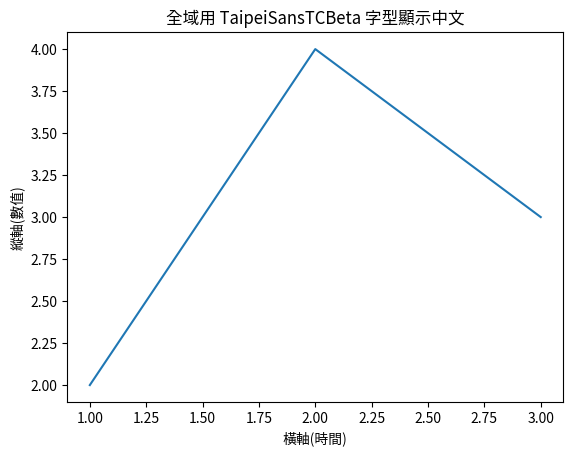

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. 把你的字型檔路徑放到變數裡
font_path = "./font/TaipeiSansTCBeta-Regular.ttf"

# 2. 將字型加到 Matplotlib 的字型清單裡
fm.fontManager.addfont(font_path)

# 3. 取出這個字型的「內部名稱」（FontProperties.get_name() 會拿到 ttf 裡面定義的字型名稱）
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()   # 例如會得到 "Taipei Sans TC Beta" 或類似的字型名稱

# 4. 把全域 rcParams 改掉，讓 sans-serif 第一順位就是這個名稱
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [font_name]  # 以剛剛抓到的名稱為準

# 5. 讓負號正常顯示
plt.rcParams['axes.unicode_minus'] = False

# 測試一下
x = [1, 2, 3]
y = [2, 4, 3]
plt.plot(x, y)
plt.title("全域用 TaipeiSansTCBeta 字型顯示中文")
plt.xlabel("橫軸(時間)")
plt.ylabel("縱軸(數值)")
plt.show()


## 2. 資料前處理

In [4]:
udn = pd.read_csv("raw_data/Merged.csv")  # 匯資料
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt
1,2,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,qazxc1156892,Tech_Job,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abc21086999""...",223.137.1.131,2024-05-02 02:19:38,ptt
2,3,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,pl132,Tech_Job,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ling621"", ""c...",180.177.2.112,2024-05-02 02:19:38,ptt


In [5]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['artDate'], errors="coerce", format="%Y-%m-%d %H:%M:%S")
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory,artDate
0,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Tech_Job,2024-05-01 16:50:30
1,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經濟日報記者葉卉軒台北即時報導年後轉職潮...,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,Tech_Job,2024-05-01 17:24:04
2,訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫研發台版大型繁中語言模型台大資工系...,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,Tech_Job,2024-05-01 17:48:08
3,首屆台法科研會議吳政忠六大領域可望締造雙贏圖左起國科會副主委陳儀莊國科會主委吳政忠法國在台協...,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,Tech_Job,2024-05-01 21:41:58
4,網誌版商科學士傳產生管年多益金色前份半路出家去寫程式資訊業不太適應就回到製造業而在科技業寒冬...,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,Tech_Job,2024-05-01 21:43:46


In [6]:
# invalid_idx = udn[udn["artDate_parsed"].isna()].index
# print("以下列的 artDate 解析失敗：")
# print(invalid_idx)
# print(udn.loc[invalid_idx, "artDate"].unique())

In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /home/vince-ylf/NSYSU/113-2/SMA/week09/dict/dict.txt.big ...
2025-06-05 20:27:04,234 : DEBUG : Building prefix dict from /home/vince-ylf/NSYSU/113-2/SMA/week09/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u02a3275727c6ca2189ef7a250cb187d0.cache
2025-06-05 20:27:04,235 : DEBUG : Loading model from cache /tmp/jieba.u02a3275727c6ca2189ef7a250cb187d0.cache
Loading model cost 0.500 seconds.
2025-06-05 20:27:04,735 : DEBUG : Loading model cost 0.500 seconds.
Prefix dict has been built successfully.
2025-06-05 20:27:04,736 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Tech_Job,2024-05-01 16:50:30,"[明顯, 之前, 面試, 遇過, 明擺, 著開, 太高, 陣子, 業界, 很凍, 現在, 好..."
1,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經濟日報記者葉卉軒台北即時報導年後轉職潮...,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,Tech_Job,2024-05-01 17:24:04,"[新聞標題, 轉職, 熱門, 公司, 出爐, 前三名, 台積電, 華碩, 台達電, 經濟日報..."
2,訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫研發台版大型繁中語言模型台大資工系...,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,Tech_Job,2024-05-01 17:48:08,"[訓練, 台版, 語言, 模型, 許永真, 百工, 百業, 商用, 國科會, 去年, 啟動,..."
3,首屆台法科研會議吳政忠六大領域可望締造雙贏圖左起國科會副主委陳儀莊國科會主委吳政忠法國在台協...,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,Tech_Job,2024-05-01 21:41:58,"[首屆, 台法, 科研, 會議, 吳政忠, 六大, 領域, 可望, 締造, 雙贏, 圖左, ..."
4,網誌版商科學士傳產生管年多益金色前份半路出家去寫程式資訊業不太適應就回到製造業而在科技業寒冬...,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,Tech_Job,2024-05-01 21:43:46,"[網誌, 商科, 學士, 產生, 管年, 多益, 金色, 前份, 半路出家, 程式, 資訊業..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [8]:
udn['artCatagory'].unique()

array(['Tech_Job', 'Salary', 'job'], dtype=object)

#### 用各個主題常見的詞來作為主題的代表詞

In [9]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == 'Tech_Job',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['公司', '晶片', '台灣', '美國', '表示', '技術', '科技', '產業', '工作', '中國', '半導體', '輝達',
       '市場', '發展', '英特爾', '報導', '未來', '全球', '台積電', '模型', '員工', '投資', '人工智慧',
       '產品', '企業', '指出', '問題', '合作', '目前', '領域', '設計', '億美元', '相關', '提供', '台積',
       '需求', '客戶', '研究', '仁勳', '製造', '中心', '需要', '進行', '今年', '時間', '資料', '研發',
       '使用', '認為', '已經', '工程師', '開發', '生產', '成長', '先進', '應用', '現在', '機器人',
       '蘋果', '執行長', '人才', '積電', '包括', '智慧', '面試', '能力', '系統', '伺服器', '持續',
       '主要', '重要', '透過', '三星', '電腦', '正在', '政府', '記者', '預計', '製程', '團隊', '推出',
       '國家', '計畫', '軟體', '影響', '運算', '主管', '業務', '希望', '機會', '供應鏈', '超過', '成為',
       '代工', '宣布', '國際', '推動', '微軟', '服務', '台北'],
      dtype='object', name='words')

In [10]:
stock_cnt = udn.loc[udn['artCatagory'] == 'Salary',:]['words'].explode().value_counts().head(200)
pprint(" ".join(stock_cnt.index))

('公司 工作 面試 薪資 主管 研究 職缺 時間 履歷 問卷 問題 員工 知道 需要 機會 經驗 目前 市場 填答 覺得 設計 科技 希望 真的 現在 '
 '產業 相關 建議 提供 業務 比較 報名 企業 薪水 台灣 資料 應該 分鐘 找到 填寫 投遞 直接 已經 內容 分享 一些 專案 能力 未來 轉職 '
 '訓練 資訊 年薪 方式 離職 職場 客戶 之後 以上 當時 工程師 主要 最後 過程 產品 一下 開發 兩個 一定 就業 職位 符合 世代 上班 看到 '
 '進行 表示 管理 收到 事情 上課 壓力 連結 所有 同事 選擇 要求 目標 公務員 專業 三個 領域 透過 網站 辦公室 拿到 視覺 技術 求職 調查 '
 '單位 一年 像是 老闆 參與 我會 聯絡 準備 影響 了解 步驟 東西 是否 軟體 感謝 加班 生活 一個月 活動 對象 說明 大學 興趣 台北 有點 '
 '幾個 來說 通知 一家 獎金 知名 使用 一直 萬元 詢問 一份 之前 環境 待業 原本 策略 不用 遇到 職涯 條件 人才 銀行 服務 團隊 這件 '
 '網址 一間 計畫 決定 經歷 國立 課程 電話 影片 部門 謝謝 日本 以下 溝通 幫忙 完成 根本 高薪 無法 發展 協助 抽獎 提到 免費 徵才 '
 '關係 去年 期間 二面 報考 對方 需求 霸凌 一次 辦法 感覺 地點 確認 確定 離開 最近 人力 人員 調整 穩定 完全 整個 不好 回覆 過去')


In [11]:
global_cnt = udn.loc[udn['artCatagory'] == 'job',:]['words'].explode().value_counts().head(200)
pprint(" ".join(global_cnt.index))

('工作 法律 文章 刪除 相關 性別 服務 通知 勞健 配合 勞基法 就業 經驗 能力 計畫 平等 確實 同意 違反 禁止 遵循 現行 張貼 發文者 確知 '
 '文責自負 兩行 保此 資料 二日 遵守 小時 資方 應徵 助理 公司 協助 月薪 研究 履歷 語言 業務 管理 以上 行政 內容 被刪 溝通 交辦 員工 '
 '時間 人員 身心 事項 福利 週休 執行 障礙 身分 具備 會員 予以 年齡 思想 以往 傾向 宗教 出生地 工會 黨派 籍貫 婚姻 容貌 歧視 五官 '
 '活動 大學 台北市 專案 註明 薪資 獎金 尤佳 辦理 作業 年終獎金 面試 電話 學士 專任 額外 主管 碩士 加班費 有限公司 彈性 補助 工時 '
 '提供 團隊 週一 週五 自傳 處理 保是 違法 保無勞健 此欄 方式 經歷 請貼 畢業 熟悉 周休 中心 禮金 午休 學習 每週 協調 負責 合作 姓名 '
 '規定 國立 主旨 資訊 教育部 另行通知 撰寫 年月日 軟體 超過 寄至 聯絡 社群 職缺 細心 三節 文件 教育 聯絡人 行銷 條件 需求 訓練 科系 '
 '學歷 小姐 資格 規劃 良好 國內外 調整 履歷表 歡迎 國定假日 電腦 上班 第一年 安排 生日 聚餐 分析 畢業證書 未達 請將 加班 文書處理 '
 '英語 維護 製作 專員 到職 信箱 教學 操作 休假 客戶 英文 時薪 聯繫 會議 文書 系統 包含 興趣 符合 請於 一年 不定期 進行 午時 旅遊 '
 '休息 比例 具有 證照 新北市 審查')


In [12]:
custom_topic_word = {
    "法律與合規": [
        "法律", "勞基法", "違反", "禁止", "遵循", "平等", "性別", "歧視",
        "工作時間", "加班費", "工時", "薪資規定", "週休", "休假", "福利", 
        "資格審查", "年齡限制", "身分證明", "文責自負", "違法", "遵守"
    ],
    "求職與面試": [
        "求職", "面試", "履歷", "自傳", "應徵", "資格", "學歷", "技能",
        "聯絡方式", "面試邀約", "電話", "電子郵件", "報名", "公告", 
        "職缺", "工作機會", "應聘", "人員需求", "專案", "主管評估"
    ],
    "薪資與福利": [
        "薪資", "月薪", "年薪", "加班費", "時薪", "獎金", "年終獎金", "補助",
        "津貼", "福利", "保險", "勞健保", "假日加給", "週休二日", "彈性上下班",
        "休假制度", "午休", "禮金", "旅遊補貼", "聚餐", "生日福利"
    ],
    "職場經驗與職涯發展": [
        "工作", "經驗", "能力", "職缺", "產業", "轉職", "管理", "團隊", 
        "訓練", "職場", "升遷", "壓力", "職涯規劃", "職位", "發展", 
        "業務", "客戶", "專業成長", "行銷", "執行", "協調"
    ],
    "科技與產業新聞": [
        "科技", "產業", "半導體", "人工智慧", "台積電", "輝達", "英特爾",
        "晶片", "全球", "市場", "研發", "製造", "供應鏈", "成長", "投資", 
        "台灣", "中國", "美國", "全球布局", "未來趨勢", "企業動態", "研發中心"
    ],
}


從 custom_topic_word 的所有值中，整理出不重複的詞彙（vocabularies），並以 NumPy 陣列的形式儲存。

In [13]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [14]:
vocabularies

array(['中國', '主管評估', '人員需求', '人工智慧', '企業動態', '休假', '休假制度', '供應鏈', '保險',
       '假日加給', '全球', '全球布局', '公告', '加班費', '勞健保', '勞基法', '升遷', '午休', '半導體',
       '協調', '台灣', '台積電', '團隊', '執行', '報名', '壓力', '學歷', '客戶', '專案',
       '專業成長', '履歷', '工作', '工作時間', '工作機會', '工時', '市場', '平等', '年終獎金', '年薪',
       '年齡限制', '彈性上下班', '性別', '應徵', '應聘', '成長', '技能', '投資', '文責自負',
       '旅遊補貼', '時薪', '晶片', '月薪', '未來趨勢', '業務', '歧視', '求職', '法律', '津貼',
       '獎金', '生日福利', '產業', '發展', '研發', '研發中心', '禁止', '福利', '禮金', '科技',
       '管理', '經驗', '美國', '聚餐', '聯絡方式', '職位', '職場', '職涯規劃', '職缺', '能力',
       '自傳', '英特爾', '薪資', '薪資規定', '行銷', '補助', '製造', '訓練', '資格', '資格審查',
       '身分證明', '輝達', '轉職', '週休', '週休二日', '違反', '違法', '遵守', '遵循', '電子郵件',
       '電話', '面試', '面試邀約'], dtype='<U5')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [15]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = feature_names, data = udn_matrix)
DTM_df

,中國,主管評估,人員需求,人工智慧,企業動態,休假,休假制度,供應鏈,保險,假日加給,...,週休,週休二日,違反,違法,遵守,遵循,電子郵件,電話,面試,面試邀約
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,6,96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,1,0,0,0,0
2451,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
2452,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0
2453,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,1,0,0,0,0


針對每個「自定義主題」，統計每篇文章在該主題下出現的詞彙總次數，整理成一個DataFrame

In [16]:
df_count = pd.DataFrame({})

# k 是主題名稱，v 是這個主題下的詞彙list
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_法律與合規,topic_求職與面試,topic_薪資與福利,topic_職場經驗與職涯發展,topic_科技與產業新聞
0,0,6,1,2,0
1,3,8,13,19,10
2,0,1,0,10,9
3,0,0,0,3,15
4,4,117,6,71,24
...,...,...,...,...,...
2450,15,1,3,4,4
2451,10,0,1,2,0
2452,16,0,5,3,0
2453,11,1,1,4,0


把每篇文章在各個主題的出現次數轉換成主題分佈機率（比例），也就是 每篇文章屬於各個主題的相對權重（theta 向量）

In [17]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_法律與合規,topic_求職與面試,topic_薪資與福利,topic_職場經驗與職涯發展,topic_科技與產業新聞
0,0.000000,0.666667,0.111111,0.222222,0.000000
1,0.056604,0.150943,0.245283,0.358491,0.188679
2,0.000000,0.050000,0.000000,0.500000,0.450000
3,0.000000,0.000000,0.000000,0.166667,0.833333
4,0.018018,0.527027,0.027027,0.319820,0.108108


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

In [18]:
# sklearn DTM
vocab = {'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

sample_docs = ["小美 喜歡 自然語言處理","小美 喜歡 文字分析"]
vectorizer = CountVectorizer(vocabulary=vocab)
dtm = vectorizer.fit_transform(sample_docs)
features = vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=features)
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


In [19]:
# for gensim
sample_docs2 =  [doc.split() for doc in sample_docs]
sample_docs2

[['小美', '喜歡', '自然語言處理'], ['小美', '喜歡', '文字分析']]

In [20]:
dct = Dictionary(sample_docs2)
print(dct)

2025-06-05 20:27:12,087 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-05 20:27:12,088 : INFO : built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)
2025-06-05 20:27:12,088 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)", 'datetime': '2025-06-05T20:27:12.088537', 'gensim': '4.3.3', 'python': '3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]', 'platform': 'Linux-6.8.0-60-generic-x86_64-with-glibc2.35', 'event': 'created'}


Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']>


In [21]:
# 可以看到每個字都被 map 到一個特定的數字
dct.token2id

{'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

In [22]:
# BOW of gensim
print(sample_docs2[0])
dct.doc2bow(sample_docs2[0])

['小美', '喜歡', '自然語言處理']


[(0, 1), (1, 1), (2, 1)]

- id為0的詞  '小美' 出現 1 次
- id為1的詞 '喜歡' 出現 1 次
- id為2的詞 '自然語言處理' 出現 1 次

In [23]:
sample_corpus = [dct.doc2bow(doc) for doc in sample_docs2]
sample_corpus

[[(0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (3, 1)]]

Gensim 的 corpus（BOW 形式）轉換成 Dense DTM（Document-Term Matrix）格式

In [24]:
# corpus 轉換成 DTM
dtm_c = corpus2dense(sample_corpus, num_terms=len(dct.token2id), num_docs=len(sample_corpus))
dtm_c

array([[1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

此時dtm_c的形式是詞彙在橫行上，文件在直列上，將其倒置可以變換回我們熟悉的DTM格式

In [25]:
dtm_c.T

array([[1., 1., 1., 0.],
       [1., 1., 0., 1.]], dtype=float32)

In [26]:
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


### **4.1 正式處理新聞**

將斷詞後的`doc['words']`轉換成list

In [27]:
docs = udn['words'].to_list()
docs[0]

['明顯',
 '之前',
 '面試',
 '遇過',
 '明擺',
 '著開',
 '太高',
 '陣子',
 '業界',
 '很凍',
 '現在',
 '好像',
 '畢業',
 '整個',
 '充滿',
 '求職',
 '焦慮',
 '覺得',
 '工作',
 '公司',
 '知名度',
 '公司',
 '反正',
 '沒得',
 '選先',
 '拿到',
 '面試',
 '機會',
 '拿到',
 '面試',
 '邀請',
 '生醫',
 '影像',
 '公司',
 '寫給',
 '薪萬',
 '範圍',
 '大到',
 '沒寫',
 '怪怪的',
 '前面',
 '沒得選',
 '去面',
 '前面',
 '例行',
 '介紹',
 '經歷',
 '公司',
 '小小的',
 '考核',
 '標準答案',
 '那種',
 '我會',
 '最後',
 '面試',
 '主管',
 '問我',
 '期望',
 '待遇',
 '原本',
 '公司',
 '規定',
 '混過去',
 '心裡',
 '想著',
 '新鮮',
 '要求',
 '主管',
 '強硬',
 '要求',
 '我給',
 '數字',
 '資會',
 '開太高',
 '二面',
 '這是',
 '原話',
 '知道',
 '講萬',
 '一定',
 '最好',
 '薪水',
 '暑期',
 '實習',
 '還低',
 '真的',
 '講不出',
 '講了',
 '範圍',
 '最後',
 '意外',
 '無聲',
 '上面',
 '薪資',
 '範圍',
 '意外',
 '最低',
 '上限',
 '寫爽',
 '職缺',
 '可憐']

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [28]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-06-05 20:27:12,543 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-05 20:27:12,702 : INFO : built Dictionary<39043 unique tokens: ['一定', '上限', '上面', '主管', '之前']...> from 2455 documents (total 503988 corpus positions)
2025-06-05 20:27:12,702 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<39043 unique tokens: ['一定', '上限', '上面', '主管', '之前']...> from 2455 documents (total 503988 corpus positions)", 'datetime': '2025-06-05T20:27:12.702678', 'gensim': '4.3.3', 'python': '3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]', 'platform': 'Linux-6.8.0-60-generic-x86_64-with-glibc2.35', 'event': 'created'}
2025-06-05 20:27:12,713 : INFO : discarding 30810 tokens: [('原話', 2), ('去面', 2), ('可憐', 3), ('大到', 4), ('寫爽', 1), ('強硬', 3), ('很凍', 1), ('想著', 4), ('我給', 3), ('明擺', 1)]...
2025-06-05 20:27:12,713 : INFO : keeping 8233 tokens which were in no less than 5 and no more than 2430 (=99.0%) documents
2025-06-05 20:27:12,719 : INFO : resulting dictionary: Dict

Dictionary<8233 unique tokens: ['一定', '上限', '上面', '主管', '之前']...>


參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

In [29]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一定: 0
上限: 1
上面: 2
主管: 3
之前: 4
二面: 5
介紹: 6
例行: 7
充滿: 8
公司: 9
前面: 10
原本: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [30]:
pprint(" ".join(udn['words'].iloc[600]))


('加速 台灣 百萬美元 富翁 爆發 全球 資產 管理機構 湧向 台灣 分一杯羹 台灣 位處 熱潮 核心 地位 擁有 先進 半導體 關鍵技術 正為 台灣 '
 '帶來 財富 快速 成長 以年 來說 台灣 人口 金融 房地產 資產 達兆 美元 相較 增加 至少 有家 全球 金融機構 正在 加強 台灣 業務 安聯 '
 '環球 投資 一家 德國 金融機構 管理 超過 台幣 億美元 資金 目前 推出 一支 專注 人工智慧 基金 計劃 建立 台灣 投資 團隊 總部 位於 美國 '
 '田納西州 納許 維爾 聯博 資產 管理 考慮 擴大 台北 辦事處 推新 產品 保德信 金融 集團 旗下 保德信 投資 管理 台灣 提供 交易 摩根 大通 '
 '推出 一款 專為 台灣 投資人 量身 定製 共同 基金 只用 一週 時間 籌集 億新 台幣 安聯 投信 預計 人工智慧 產業 將為 台灣 創造 超過 '
 '億美元 財富 瑞銀 集團 預測 為止 五年 內台灣 百萬美元 富翁 數量 增長 一半 全球 市場 成長 最快 地區 總計 達到 近萬人 全球 資產 '
 '管理機構 正在 台灣 尋找 身價 萬美元 企業家 客戶 過去 喜愛 定期存款 保單 投資 客戶 目前 傾向 報酬 債券 瑞銀 資產 管理 駐台灣 投資 '
 '主管 表示 目前 已經 看到 波動性 低收入 可觀 具有 潛在 資本 收益 固定 收益 產品 越來越 受歡迎 全世界 人工智慧 投資 情緒 樂觀 引發 '
 '許多 台灣 投資人 借錢 股票 但當 股價 下跌 投資人 迅速 拋售 加劇 市場 低迷 像是 今年 月初 引發 拋售 日圓 掛鉤 熱門 貨幣 交易 平倉 '
 '重創 全球股市 引發 台股 年來 史上 最大 跌幅 跨國企業 面臨 來自 台灣 國內 基金 經理人 激烈 競爭 一些 華爾街 資深 人士 公司 現在 '
 '正在 不斷 壯大 台灣 當地 經驗 具有 優勢 國泰 投信 董事長 張錫 表示 台灣 投資 機構 跨國企業 了解 這裡 市場 人工智慧 繁榮 正在 創造 '
 '財富 投資者 正在 改變 投資 組合 組成 國泰 投信 當地 投信 正在 創建 主動式 這是 台灣 金融監管 機關 最近 批准 投資 工具 摩根 大通 '
 '野村 資產 管理 公司 表態 正在 考慮 規劃 這類 投資 工具 公司 面對 投

第600篇文章的前十個詞彙的語料庫ID和頻率

In [31]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(3, 1),
 (6, 1),
 (9, 4),
 (37, 1),
 (42, 1),
 (58, 1),
 (68, 3),
 (75, 1),
 (89, 1),
 (93, 1)]

#### 將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [32]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

### **4.2 開始訓練 LDA topic model**

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [33]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-06-05 20:27:12,984 : INFO : using symmetric alpha at 0.1
2025-06-05 20:27:12,985 : INFO : using symmetric eta at 0.1
2025-06-05 20:27:12,986 : INFO : using serial LDA version on this node
2025-06-05 20:27:12,989 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 2455 documents, updating model once every 2000 documents, evaluating perplexity every 2455 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-05 20:27:12,989 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-05 20:27:12,989 : INFO : PROGRESS: pass 0, at document #2000/2455
2025-06-05 20:27:13,510 : INFO : merging changes from 2000 documents into a model of 2455 documents
2025-06-05 20:27:13,512 : INFO : topic #1 (0.100): 0.012*"公司" + 0.009*"工作" + 0.008*"晶片" + 0.005*"表示" + 0.005*"技術" + 0.004*"相關" + 0.004*"市場" + 0.004*"輝達" + 0.004*"面試" + 0.004*"產品"
2025-06-05 20:27

### **4.3 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [34]:
ldamodel.print_topics()

2025-06-05 20:27:13,786 : INFO : topic #0 (0.100): 0.028*"工作" + 0.012*"文章" + 0.011*"法律" + 0.010*"刪除" + 0.010*"公司" + 0.008*"勞健" + 0.007*"勞基法" + 0.007*"性別" + 0.006*"服務" + 0.006*"保此"
2025-06-05 20:27:13,786 : INFO : topic #1 (0.100): 0.011*"公司" + 0.009*"工作" + 0.008*"晶片" + 0.005*"表示" + 0.004*"技術" + 0.004*"市場" + 0.004*"相關" + 0.004*"輝達" + 0.004*"面試" + 0.004*"產品"
2025-06-05 20:27:13,786 : INFO : topic #2 (0.100): 0.011*"工作" + 0.010*"公司" + 0.007*"美國" + 0.005*"技術" + 0.005*"台灣" + 0.005*"表示" + 0.004*"輝達" + 0.004*"中心" + 0.004*"研發" + 0.004*"提供"
2025-06-05 20:27:13,786 : INFO : topic #3 (0.100): 0.019*"工作" + 0.007*"經驗" + 0.006*"公司" + 0.006*"能力" + 0.006*"產品" + 0.005*"文章" + 0.004*"管理" + 0.004*"團隊" + 0.004*"具備" + 0.004*"刪除"
2025-06-05 20:27:13,787 : INFO : topic #4 (0.100): 0.009*"晶片" + 0.008*"公司" + 0.007*"產業" + 0.006*"台灣" + 0.006*"英特爾" + 0.006*"工作" + 0.005*"未來" + 0.004*"設計" + 0.004*"科技" + 0.004*"全球"
2025-06-05 20:27:13,787 : INFO : topic #5 (0.100): 0.018*"工作" + 0.010*"研究" + 0.006*"法律" + 0.006*"應徵" + 

[(0,
  '0.028*"工作" + 0.012*"文章" + 0.011*"法律" + 0.010*"刪除" + 0.010*"公司" + 0.008*"勞健" + 0.007*"勞基法" + 0.007*"性別" + 0.006*"服務" + 0.006*"保此"'),
 (1,
  '0.011*"公司" + 0.009*"工作" + 0.008*"晶片" + 0.005*"表示" + 0.004*"技術" + 0.004*"市場" + 0.004*"相關" + 0.004*"輝達" + 0.004*"面試" + 0.004*"產品"'),
 (2,
  '0.011*"工作" + 0.010*"公司" + 0.007*"美國" + 0.005*"技術" + 0.005*"台灣" + 0.005*"表示" + 0.004*"輝達" + 0.004*"中心" + 0.004*"研發" + 0.004*"提供"'),
 (3,
  '0.019*"工作" + 0.007*"經驗" + 0.006*"公司" + 0.006*"能力" + 0.006*"產品" + 0.005*"文章" + 0.004*"管理" + 0.004*"團隊" + 0.004*"具備" + 0.004*"刪除"'),
 (4,
  '0.009*"晶片" + 0.008*"公司" + 0.007*"產業" + 0.006*"台灣" + 0.006*"英特爾" + 0.006*"工作" + 0.005*"未來" + 0.004*"設計" + 0.004*"科技" + 0.004*"全球"'),
 (5,
  '0.018*"工作" + 0.010*"研究" + 0.006*"法律" + 0.006*"應徵" + 0.005*"午時" + 0.005*"勞基法" + 0.005*"小時" + 0.005*"語言" + 0.005*"服務" + 0.005*"延長"'),
 (6,
  '0.024*"工作" + 0.012*"法律" + 0.011*"相關" + 0.011*"文章" + 0.010*"刪除" + 0.009*"性別" + 0.008*"服務" + 0.008*"通知" + 0.008*"計畫" + 0.007*"就業"'),
 (7,
  '0.008*"台灣" + 0.0

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：春節旅遊
+ 主題二：中國科技產業
+ 主題三：股市新聞
+ 主題四：中國股市
+ ...
+ 主題十：中美貿易

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [35]:
ldamodel.get_document_topics(corpus[0])

[(1, 0.505998), (2, 0.48397347)]

這邊可以看到corpus[0]這篇文章是由多個主題混合組成，每個主題都有其機率（權重）
其中主題4的佔比最高(0.77)

### **4.4 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [36]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-06-05 20:27:14,763 : INFO : -7.801 per-word bound, 223.1 perplexity estimate based on a held-out corpus of 2455 documents with 447504 words


-7.801241782124244

將 對數 perplexity 值轉回原始的 perplexity 值

In [37]:
np.exp2(-perplexity)

223.0528516169212

In [38]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-06-05 20:27:14,828 : INFO : using ParallelWordOccurrenceAccumulator<processes=19, batch_size=64> to estimate probabilities from sliding windows
2025-06-05 20:27:14,937 : INFO : 1 batches submitted to accumulate stats from 64 documents (16375 virtual)
2025-06-05 20:27:14,940 : INFO : 2 batches submitted to accumulate stats from 128 documents (34482 virtual)
2025-06-05 20:27:14,942 : INFO : 3 batches submitted to accumulate stats from 192 documents (47637 virtual)
2025-06-05 20:27:14,943 : INFO : 4 batches submitted to accumulate stats from 256 documents (59683 virtual)
2025-06-05 20:27:14,945 : INFO : 5 batches submitted to accumulate stats from 320 documents (71634 virtual)
2025-06-05 20:27:14,946 : INFO : 6 batches submitted to accumulate stats from 384 documents (87896 virtual)
2025-06-05 20:27:14,948 : INFO : 7 batches submitted to accumulate stats from 448 documents (101125 virtual)
2025-06-05 20:27:14,949 : INFO : 8 batches submitted to accumulate stats from 512 documents (11

這個主題模型的 PMI score:  -0.019127670926106243


也可以列出主題模型中，每個主題詞語之間的PMI score

In [39]:
NPMI_model_lda.get_coherence_per_topic()

[0.10147605817847424,
 -0.030736350940495333,
 -0.02796051968550082,
 -0.05423840247781371,
 0.030131011125848782,
 -0.12005204528916238,
 0.04791336737972165,
 -0.12554247219281917,
 0.009717435291362302,
 -0.021984790650678026]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

### **4.5 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [40]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2025-06-05 20:27:15,467 : INFO : using symmetric alpha at 0.5
2025-06-05 20:27:15,469 : INFO : using symmetric eta at 0.5
2025-06-05 20:27:15,472 : INFO : using serial LDA version on this node
2025-06-05 20:27:15,475 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 2455 documents, updating model once every 2000 documents, evaluating perplexity every 2455 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-05 20:27:15,476 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-05 20:27:15,477 : INFO : PROGRESS: pass 0, at document #2000/2455
2025-06-05 20:27:15,898 : INFO : merging changes from 2000 documents into a model of 2455 documents
2025-06-05 20:27:15,898 : INFO : topic #0 (0.500): 0.008*"公司" + 0.007*"工作" + 0.007*"晶片" + 0.006*"相關" + 0.005*"表示" + 0.005*"產業" + 0.005*"技術" + 0.004*"市場" + 0.004*"科技" + 0.004*"台灣"
2025-06-05 20:27:1

花費時間: 31.356601238250732 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [41]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,1843.710905,0.049902
1,3,1797.017204,0.041751
2,4,1731.596318,0.051389
3,5,1692.279358,0.027423
4,6,1680.706586,-0.015539
5,7,1643.750643,-0.009972
6,8,1624.685409,0.006021
7,9,1630.744169,0.036760


<Axes: xlabel='topic_num'>

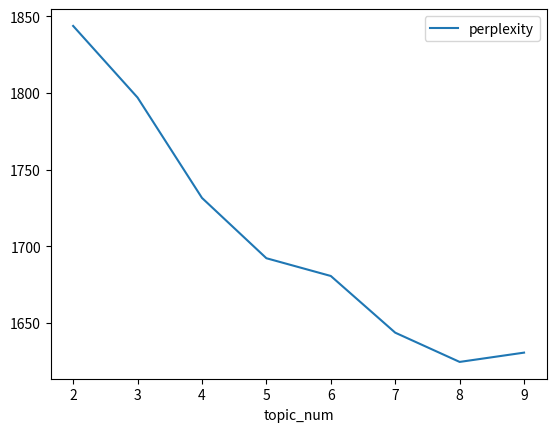

In [42]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

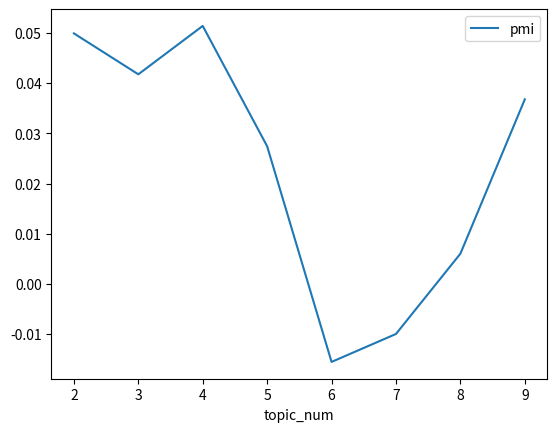

In [43]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 5 之後都不錯，coherence 最高則是 8

## 5. 視覺化呈現

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [44]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2025-06-05 20:27:47,069 : INFO : using symmetric alpha at 0.125
2025-06-05 20:27:47,069 : INFO : using symmetric eta at 0.125
2025-06-05 20:27:47,070 : INFO : using serial LDA version on this node
2025-06-05 20:27:47,072 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 2455 documents, updating model once every 2000 documents, evaluating perplexity every 2455 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-05 20:27:47,073 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-05 20:27:47,073 : INFO : PROGRESS: pass 0, at document #2000/2455
2025-06-05 20:27:47,550 : INFO : merging changes from 2000 documents into a model of 2455 documents
2025-06-05 20:27:47,551 : INFO : topic #6 (0.125): 0.011*"工作" + 0.005*"公司" + 0.005*"能力" + 0.005*"表示" + 0.005*"文章" + 0.005*"研究" + 0.004*"晶片" + 0.004*"相關" + 0.004*"服務" + 0.004*"中國"
2025-06-05 20:

In [45]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.258179 -0.035107       1        1  28.143692
5     -0.205425  0.038146       2        1  18.965377
6     -0.248015 -0.011485       3        1  15.895691
7      0.158650 -0.015902       4        1  15.428264
2      0.154905 -0.046324       5        1  13.961361
1     -0.230300 -0.151533       6        1   3.721539
0      0.145239 -0.021086       7        1   2.432913
3     -0.033233  0.243291       8        1   1.451163, topic_info=     Term         Freq        Total Category  logprob  loglift
19     工作  5725.000000  5725.000000  Default  30.0000  30.0000
98     員工  1286.000000  1286.000000  Default  29.0000  29.0000
9      公司  3271.000000  3271.000000  Default  28.0000  28.0000
3742   法律  2069.000000  2069.000000  Default  27.0000  27.0000
387    晶片  1976.000000  1976.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1474   廣達    23.140321   159.410807   Topic8  -5.6371   2.3029
55     規定    25.087094   369.668767   Topic8  -5.5563   1.5426
139    月薪    25.800891   762.366586   Topic8  -5.5282   0.8468
842    相關    26.909520  2370.207512   Topic8  -5.4862  -0.2454
757    時間    25.393723  1125.657998   Topic8  -5.5441   0.4412

[684 rows x 6 columns], token_table=      Topic      Freq Term
term                      
464       1  0.026996   一下
464       2  0.006749   一下
464       3  0.006749   一下
464       4  0.917859   一下
464       5  0.040494   一下
...     ...       ...  ...
5359      4  0.041770  魏哲家
5359      5  0.008354  魏哲家
7463      2  0.950993   點心
7179      2  0.705284   黨派
7179      3  0.290529   黨派

[2186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 7, 8, 3, 2, 1, 4])

可以看到(7,8)、(3,6)和(2,5)很相近，試試看跑5個主題

In [46]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-06-05 20:27:51,033 : INFO : using symmetric alpha at 0.2
2025-06-05 20:27:51,033 : INFO : using symmetric eta at 0.2
2025-06-05 20:27:51,034 : INFO : using serial LDA version on this node
2025-06-05 20:27:51,036 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2455 documents, updating model once every 2000 documents, evaluating perplexity every 2455 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-05 20:27:51,036 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-05 20:27:51,036 : INFO : PROGRESS: pass 0, at document #2000/2455
2025-06-05 20:27:51,471 : INFO : merging changes from 2000 documents into a model of 2455 documents
2025-06-05 20:27:51,473 : INFO : topic #0 (0.200): 0.007*"工作" + 0.006*"相關" + 0.005*"晶片" + 0.005*"公司" + 0.004*"產業" + 0.004*"技術" + 0.004*"中心" + 0.004*"表示" + 0.004*"員工" + 0.004*"提供"
2025-06-05 20:27:5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.242705  0.062106       1        1  44.859116
3     -0.220302  0.054869       2        1  18.992820
1     -0.225901 -0.057970       3        1  17.675184
2      0.049961  0.067794       4        1  10.486516
0      0.153537 -0.126799       5        1   7.986363, topic_info=     Term         Freq        Total Category  logprob  loglift
19     工作  5662.000000  5662.000000  Default  30.0000  30.0000
3742   法律  2055.000000  2055.000000  Default  29.0000  29.0000
4768   刪除  1787.000000  1787.000000  Default  28.0000  28.0000
745    文章  1954.000000  1954.000000  Default  27.0000  27.0000
9      公司  3136.000000  3136.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
757    時間   127.772296  1124.746997   Topic5  -5.6338   0.3524
126    提供   120.054064  1049.905282   Topic5  -5.6961   0.3589
19     工作   143.714364  5662.191354   Topic5  -5.5162  -1.1463
670    已經   106.135529   569.936331   Topic5  -5.8193   0.8466
300    目前   103.301884   785.330451   Topic5  -5.8464   0.4990

[447 rows x 6 columns], token_table=      Topic      Freq Term
term                      
464       1  0.204394   一下
464       2  0.007570   一下
464       4  0.204394   一下
464       5  0.575332   一下
465       1  0.498028   一些
...     ...       ...  ...
7179      1  0.002039   黨派
7179      2  0.791282   黨派
7179      3  0.201899   黨派
7179      4  0.004079   黨派
7179      5  0.002039   黨派

[1292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])

替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [47]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA"

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.11.0` 可正常執行

In [48]:
import guidedlda

In [49]:
word2id = dictionary.token2id

In [50]:
seed_topic_list = [
    # 法律合規與勞動權益
    ["勞基法", "違法", "禁止", "遵循", "平等"],
    # 求職與面試流程
    ["履歷", "面試", "應徵", "職缺", "自傳"],
    # 薪資與福利制度
    ["薪資", "年薪", "加班費", "獎金", "福利"],
    # 科技與半導體產業
    ["半導體", "台積電", "晶片", "科技", "人工智慧"],
    # 企業與市場動態
    ["企業", "市場", "投資", "供應鏈", "全球"]
]


In [51]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [52]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [53]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-06-05 20:27:54,958 : INFO : n_documents: 2455
2025-06-05 20:27:54,958 : INFO : vocab_size: 8233
2025-06-05 20:27:54,958 : INFO : n_words: 447504
2025-06-05 20:27:54,958 : INFO : n_topics: 6
2025-06-05 20:27:54,958 : INFO : n_iter: 100
2025-06-05 20:27:54,964 : WARNING : all zero row in document-term matrix found
2025-06-05 20:27:56,286 : INFO : <0> log likelihood: -4487258
2025-06-05 20:27:56,453 : INFO : <20> log likelihood: -3484965
2025-06-05 20:27:56,608 : INFO : <40> log likelihood: -3455469
2025-06-05 20:27:56,762 : INFO : <60> log likelihood: -3446700
2025-06-05 20:27:56,915 : INFO : <80> log likelihood: -3442174
2025-06-05 20:27:57,065 : INFO : <99> log likelihood: -3440378


In [54]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_
# 取得corpus全部的詞彙表
vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    # 依照詞語機率從小到大排序，找出每個主題的前十個關鍵詞
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 工作 法律 文章 刪除 性別 勞健 服務 勞基法 配合 就業
Topic 1: 相關 研究 計畫 工作 資料 助理 大學 學士 專任 碩士
Topic 2: 工作 公司 員工 面試 薪資 經驗 主管 獎金 時間 工程師
Topic 3: 晶片 美國 中國 公司 英特爾 台積電 輝達 報導 表示 億美元
Topic 4: 台灣 產業 發展 企業 技術 科技 未來 全球 合作 研發
Topic 5: 公司 模型 問題 需要 使用 現在 研究 工作 技術 已經


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.290740 -0.220733       1        1  22.130262
4      0.188012 -0.031731       2        1  19.124370
3      0.263009 -0.146847       3        1  17.950890
5      0.136138  0.130207       4        1  17.191027
2     -0.080726  0.153589       5        1  12.678016
1     -0.215694  0.115514       6        1  10.925435, topic_info=     Term         Freq        Total Category  logprob  loglift
19     工作  5871.000000  5871.000000  Default  30.0000  30.0000
387    晶片  1987.000000  1987.000000  Default  29.0000  29.0000
3742   法律  2046.000000  2046.000000  Default  28.0000  28.0000
745    文章  1947.000000  1947.000000  Default  27.0000  27.0000
306    美國  1761.000000  1761.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
63     面試   292.569739  1040.595264   Topic6  -5.1187   0.9452
904    能力   324.521658  1557.297177   Topic6  -5.0150   0.6457
1684   執行   245.640359   660.280063   Topic6  -5.2935   1.2253
1747   以上   244.641862   872.987349   Topic6  -5.2976   0.9420
1950   通知   222.674917  1359.591002   Topic6  -5.3917   0.4049

[438 rows x 6 columns], token_table=      Topic      Freq Term
term                      
465       3  0.088053   一些
465       4  0.912820   一些
1172      4  1.000098   一堆
1638      4  1.000599   一種
480       5  0.999656   一面
...     ...       ...  ...
2629      3  1.000482   高通
5359      3  1.000529  魏哲家
1040      2  1.000559   鴻海
7179      1  1.000845   黨派
1721      2  1.000201   龐大

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 6, 3, 2])

In [55]:
# 這邊又再次定義 seed_topic_list 是為了區分運動類別中的棒球 & 籃球主題
#如果覺得分類不錯的話，可以不用再多分一次看結果好不好

# seed_topic_list = [
#     ["大谷", "春訓", "聯盟", "先發", "道奇"],
#     ['湖人', '太陽', '西區', "季後賽", "助攻", '籃板', '西區', '公鹿', '獨行俠', '詹姆斯', '勇士', "快艇", "熱火", "金塊"],
#     ["股票", "投資", "外資", "利率", "基金", "台積電", "半導體", "科技", "鴻海", "電動車"],
#     ["中國", "兩岸", "習近平", "政府", "外交"],
#     ["大陸","網友","媒體","網路"],
# ]

# seed_topics = {}
# for t_id, st in enumerate(seed_topic_list):
#     for word in st:
#         seed_topics[word2id[word]] = t_id

In [56]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-06-05 20:27:57,565 : INFO : n_documents: 2455
2025-06-05 20:27:57,566 : INFO : vocab_size: 8233
2025-06-05 20:27:57,566 : INFO : n_words: 447504
2025-06-05 20:27:57,566 : INFO : n_topics: 6
2025-06-05 20:27:57,567 : INFO : n_iter: 100
2025-06-05 20:27:57,580 : WARNING : all zero row in document-term matrix found
2025-06-05 20:27:58,910 : INFO : <0> log likelihood: -4487258
2025-06-05 20:27:59,078 : INFO : <20> log likelihood: -3484965
2025-06-05 20:27:59,236 : INFO : <40> log likelihood: -3455469
2025-06-05 20:27:59,391 : INFO : <60> log likelihood: -3446700
2025-06-05 20:27:59,545 : INFO : <80> log likelihood: -3442174
2025-06-05 20:27:59,699 : INFO : <99> log likelihood: -3440378


In [57]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 工作 法律 文章 刪除 性別 勞健 服務 勞基法 配合 就業
Topic 1: 相關 研究 計畫 工作 資料 助理 大學 學士 專任 碩士
Topic 2: 工作 公司 員工 面試 薪資 經驗 主管 獎金 時間 工程師
Topic 3: 晶片 美國 中國 公司 英特爾 台積電 輝達 報導 表示 億美元
Topic 4: 台灣 產業 發展 企業 技術 科技 未來 全球 合作 研發
Topic 5: 公司 模型 問題 需要 使用 現在 研究 工作 技術 已經


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.290740 -0.220733       1        1  22.130262
4      0.188012 -0.031731       2        1  19.124370
3      0.263009 -0.146847       3        1  17.950890
5      0.136138  0.130207       4        1  17.191027
2     -0.080726  0.153589       5        1  12.678016
1     -0.215694  0.115514       6        1  10.925435, topic_info=     Term         Freq        Total Category  logprob  loglift
19     工作  5871.000000  5871.000000  Default  30.0000  30.0000
387    晶片  1987.000000  1987.000000  Default  29.0000  29.0000
3742   法律  2046.000000  2046.000000  Default  28.0000  28.0000
745    文章  1947.000000  1947.000000  Default  27.0000  27.0000
306    美國  1761.000000  1761.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
63     面試   292.569739  1040.595264   Topic6  -5.1187   0.9452
904    能力   324.521658  1557.297177   Topic6  -5.0150   0.6457
1684   執行   245.640359   660.280063   Topic6  -5.2935   1.2253
1747   以上   244.641862   872.987349   Topic6  -5.2976   0.9420
1950   通知   222.674917  1359.591002   Topic6  -5.3917   0.4049

[438 rows x 6 columns], token_table=      Topic      Freq Term
term                      
465       3  0.088053   一些
465       4  0.912820   一些
1172      4  1.000098   一堆
1638      4  1.000599   一種
480       5  0.999656   一面
...     ...       ...  ...
2629      3  1.000482   高通
5359      3  1.000529  魏哲家
1040      2  1.000559   鴻海
7179      1  1.000845   黨派
1721      2  1.000201   龐大

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 6, 3, 2])

## 7. 主題分佈的應用，搭配其他文章資訊

訓練完LDA模型後，我們可以嘗試將訓練好的模型應用於資料集上，觀察每天主題文章的佔比變化

In [58]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [59]:
topics_doc[100]

[(0, 0.28660703), (2, 0.37921137), (4, 0.3332105)]

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [60]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.71624196, 0.        , 0.27613875, 0.        , 0.        ],
       [0.        , 0.        , 0.61079711, 0.        , 0.3864994 ],
       [0.        , 0.0363277 , 0.21155697, 0.        , 0.75035071],
       ...,
       [0.        , 0.        , 0.        , 0.99031866, 0.        ],
       [0.        , 0.43774897, 0.        , 0.55630225, 0.        ],
       [0.        , 0.44118202, 0.08983911, 0.46720618, 0.        ]])

In [61]:
# 將主題的機率分布轉換成主題標籤
udn['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [62]:
udn['topic_label'].value_counts()

topic_label
5    1088
4     570
2     463
1     171
3     163
Name: count, dtype: int64

In [63]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Tech_Job,2024-05-01 16:50:30,"[明顯, 之前, 面試, 遇過, 明擺, 著開, 太高, 陣子, 業界, 很凍, 現在, 好...",1
1,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經濟日報記者葉卉軒台北即時報導年後轉職潮...,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,Tech_Job,2024-05-01 17:24:04,"[新聞標題, 轉職, 熱門, 公司, 出爐, 前三名, 台積電, 華碩, 台達電, 經濟日報...",3
2,訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫研發台版大型繁中語言模型台大資工系...,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,Tech_Job,2024-05-01 17:48:08,"[訓練, 台版, 語言, 模型, 許永真, 百工, 百業, 商用, 國科會, 去年, 啟動,...",5
3,首屆台法科研會議吳政忠六大領域可望締造雙贏圖左起國科會副主委陳儀莊國科會主委吳政忠法國在台協...,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,Tech_Job,2024-05-01 21:41:58,"[首屆, 台法, 科研, 會議, 吳政忠, 六大, 領域, 可望, 締造, 雙贏, 圖左, ...",5
4,網誌版商科學士傳產生管年多益金色前份半路出家去寫程式資訊業不太適應就回到製造業而在科技業寒冬...,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,Tech_Job,2024-05-01 21:43:46,"[網誌, 商科, 學士, 產生, 管年, 多益, 金色, 前份, 半路出家, 程式, 資訊業...",1


#### 查看每天每個主題的文章相對比例（占比）

In [67]:
# udn['artDate'].dt.date => 資料太多，x軸太雜亂
udn.groupby(udn['artDate'].dt.month)['topic_label'].value_counts(normalize=True)

artDate  topic_label
1        5              0.520000
         4              0.200000
         2              0.142857
         3              0.074286
         1              0.062857
2        5              0.429293
         2              0.222222
         4              0.166667
         1              0.095960
         3              0.085859
3        5              0.398058
         2              0.213592
         4              0.213592
         1              0.121359
         3              0.053398
4        5              0.420118
         4              0.242604
         2              0.213018
         3              0.088757
         1              0.035503
5        5              0.465035
         4              0.227273
         2              0.181818
         3              0.073427
         1              0.052448
6        5              0.455414
         4              0.257962
         2              0.178344
         1              0.070064
         3            

In [68]:
date_topic = udn.groupby(udn['artDate'].dt.month)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
1,0.062857,0.142857,0.074286,0.200000,0.520000
2,0.095960,0.222222,0.085859,0.166667,0.429293
3,0.121359,0.213592,0.053398,0.213592,0.398058
4,0.035503,0.213018,0.088757,0.242604,0.420118
5,0.052448,0.181818,0.073427,0.227273,0.465035


#### 視覺化呈現主題文章趨勢變化

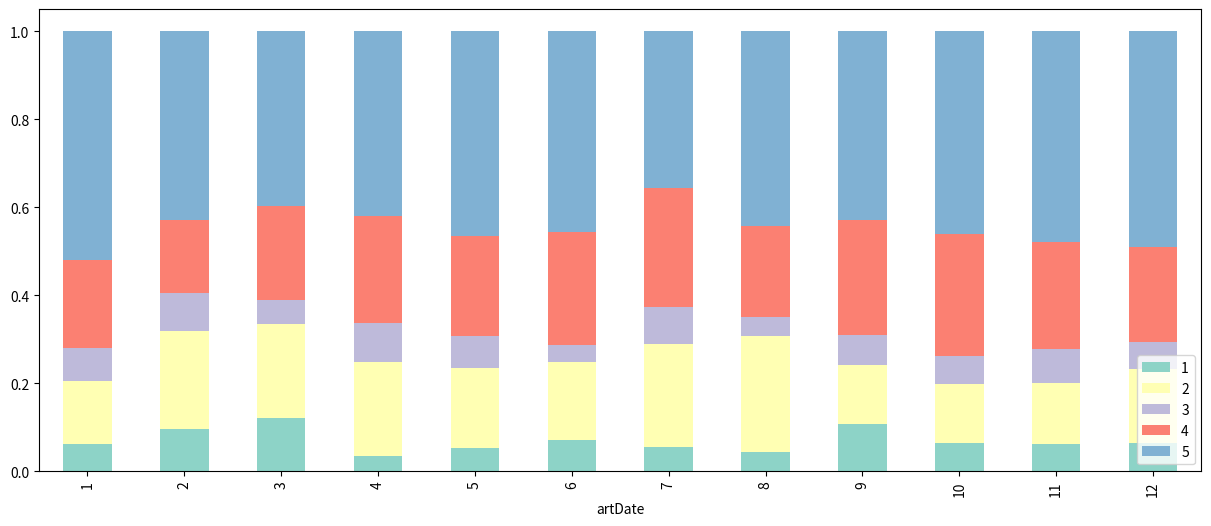

In [69]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題3（中國各產業市場）在 2/15、2/16 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。